In [1]:
from scipy.integrate import odeint
from scipy.stats import lognorm
import numpy as np
from ode_api import *
from ode_funcs import *
import matplotlib.pyplot as plt
import scipy
import pymc3 as pm

THEANO_FLAGS = 'exception_verbosity=high'

# Test: Vector ODE with 1 parameter

$$ S'= -R_0 S I \quad S(0) = 0.99 $$

$$ I' = R_0 S I - I \quad I(0) = 0.01 $$

In [2]:
#Specify how many stats, initial values, and ode parameters there are
n_states = 2
n_ics = 2
n_odeparams = 1

#Times to evaluate the solution
times = np.arange(0.25,6,0.5)

#Instantiate the ODEModel
model_1 = ODEModel(odefunc = test_ode_func_3, 
                   y0 = [0.99,0.01],
                   t0 = 0,
                    times = times,
                    n_states = n_states,
                    n_ics = n_ics,
                    n_odeparams = n_odeparams)

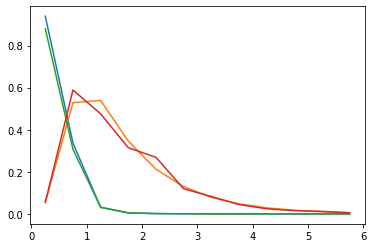

In [3]:
#Simulate the data and create data to learn from
sims, sens = model_1.simulate([8, 0.99,0.01])


S = scipy.stats.lognorm.rvs(s = 0.1, scale = sims[:,0])
I = scipy.stats.lognorm.rvs(s = 0.25, scale = sims[:,1])

Y = np.vstack([S,I])

plt.plot(times, sims)

plt.plot(times, Y.T)


In [4]:
# Now instantiate the theano custom ODE op
my_ODEop = ODEop(model_1)

In [ ]:
# The probabilistic model
with pm.Model() as first_model:

    # Priors for unknown model parameters
    BoundNormal = pm.Bound(pm.Normal,lower = 1)
    
    R = BoundNormal('R', mu = 1, sd = 5)
    
    sigma = pm.HalfCauchy('sigma',1)

    # Forward model
    all_params = pm.math.stack([R,0.99,0.01],axis=0)
    pprint = tt.printing.Print('all_params')(all_params)
    
    ode_sol = my_ODEop(all_params)
    oprint = tt.printing.Print('ode_sol')(ode_sol)
    
    forward = ode_sol.reshape(Y.shape)
    fprint = tt.printing.Print('forward')(pm.math.log(forward))
    
    

    # Likelihood 
    Y_obs = pm.Lognormal('Y_obs', mu=pm.math.log(forward), sd=sigma, observed=Y)
#     Y_obs = pm.Normal('Y_obs', mu=forward, sd=sigma, observed=Y)
#     Y_obs = pm.Lognormal('Y_obs', mu=forward, sd=sigma, observed=Y)
    
    trace = pm.sample(2000, tune=1000, chains = 4, init='adapt_diag', target_accept = 0.99)

pm.traceplot(trace)

plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


all_params __str__ = [2.   0.99 0.01]
ode_sol __str__ = [0.98440937 0.01275908 0.96842422 0.02055843 0.9434628  0.0324632
 0.90592698 0.0496999  0.85252832 0.07272242 0.78215713 0.10001823
 0.6979595  0.12726857 0.60765382 0.14829638 0.52080681 0.1580303
 0.44487283 0.15516893 0.3831498  0.14221075 0.33539553 0.12340726]
forward __str__ = [[-0.01571344 -4.36151245 -0.03208504 -3.88448443 -0.05819834 -3.42764828
  -0.09879658 -3.00175229 -0.15954885 -2.6211055  -0.24569963 -2.30240283]
 [-0.3595942  -2.06145572 -0.49814994 -1.90854244 -0.65237612 -1.84496849
  -0.80996681 -1.86324088 -0.95932925 -1.95044519 -1.09244475 -2.09226533]]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, R]
Sampling 4 chains:  16%|█▌        | 1940/12000 [06:02<44:42,  3.75draws/s]  

In [ ]:
pm.posteriorplot.plot_posterior(trace);


In [ ]:
print(pm.gelman_rubin(trace))

print(pm.effective_n(trace))

In [ ]:
with first_model:
    yppc = pm.sample_ppc(trace)

In [ ]:
Y_obs  = yppc['Y_obs']

for i in range(100):
    
    plt.plot(times, Y_obs[i].T, alpha = 0.25, color = 'C0')
    
plt.plot(times,sims, color = 'red')